## Misc. Utilities/setup

In [1]:
import os, time

from fastai.vision.all import *
from fastcore.all import *
from fastdownload import download_url

In [2]:
is_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if is_kaggle:
    data_path = Path("data")
    model_path = Path("models")
else:
    data_path = Path("../data")
    model_path = Path("../models")

data_path.mkdir(exist_ok=True, parents=True)
model_path.mkdir(exist_ok=True, parents=True)

In [3]:
def search_images(term, max_images=200):
    """
    Search duckduckgo images for the term
    """
    url = 'https://duckduckgo.com/'
    res = urlread(url, data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls, data = set(),{'next':1}
    while len(urls) < max_images and 'next' in data:
        data = urljson(requestUrl, data = params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

## Figuring out search terms to scrape

In [4]:
# urls = search_images("ev charging station", max_images=1)
# dest = data_path / "ev_test.jpg"
# download_url(urls[0], dest, show_progress=False)

# im = Image.open(dest)
# im.to_thumb(256, 256)

In [5]:
# dest = data_path / "_bike_rack_example.jpg"
# download_url(search_images("urban bike rack city", max_images=1)[0], dest, show_progress=False)

# im = Image.open(dest)
# im.to_thumb(256, 256)

In [6]:
# searches = 'ev charging station', 'urban bike rack city', 'cumulus'
searches = ("ev_charger", "ev charging station"), ("bike_rack", "urban bike rack city")

for o in searches:
    dest = data_path / o[0]

    # if the path already exists, assume we already fetched the images for this category
    if dest.exists():
        continue

    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f"{o[1]} photo", 400))
    resize_images(dest, max_size=400, dest=dest)

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [7]:
failed = verify_images(get_image_files(data_path))
failed.map(Path.unlink)
len(failed)

14

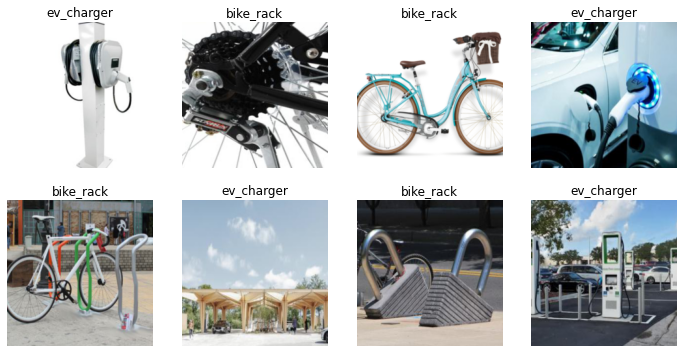

In [8]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=RandomResizedCrop(224, min_scale=0.5)
#     item_tfms=[Resize(192, method="squish")],# resize instead of RandomResizedCrop because I can't guarantee all parts of photo will feature class
)

dls = dblock.dataloaders(data_path)

dls.show_batch(max_n=8)

## Training a model to help clean data

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate, y_range=(0, 1))
learn.path = model_path
learn.fine_tune(3, 1e-3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.656869,0.451977,0.146667,01:06


epoch,train_loss,valid_loss,error_rate,time
0,0.473105,0.392031,0.053333,01:33
1,0.432331,0.365014,0.046667,01:34
2,0.408923,0.360792,0.033333,01:36


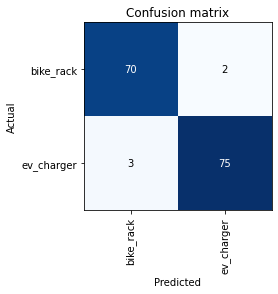

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [11]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [12]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

## Training a model post data cleanup

In [13]:
# dblock = dblock.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
# dls = dblock.dataloaders(data_path)

# learn = vision_learner(dls, resnet18, metrics=error_rate, y_range=(0, 1))
# learn.path = model_path
# learn.fine_tune(5, 1e-3)

In [14]:
!wget https://i.imgur.com/27n3FSq.png

--2022-06-02 18:46:10--  https://i.imgur.com/27n3FSq.png
Resolving i.imgur.com (i.imgur.com)... 146.75.28.193
Connecting to i.imgur.com (i.imgur.com)|146.75.28.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3799188 (3.6M) [image/png]
Saving to: ‘27n3FSq.png’

27n3FSq.png         100%[===================>]   3.62M  6.87MB/s    in 0.5s    

2022-06-02 18:46:11 (6.87 MB/s) - ‘27n3FSq.png’ saved [3799188/3799188]



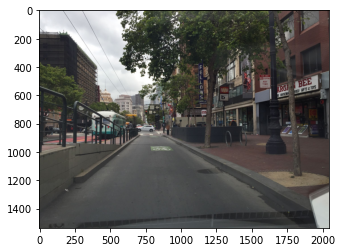

In [15]:
img = plt.imread('27n3FSq.png')
plt.imshow(img);

In [16]:
import numpy as np

img = np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((2048, 1536)).convert('RGB'))


In [17]:
learn.predict(img)

('ev_charger', TensorBase(1), TensorBase([0.2864, 0.7136]))

--2022-06-02 18:46:13--  https://i.imgur.com/ePJzE87.png
Resolving i.imgur.com (i.imgur.com)... 146.75.28.193
Connecting to i.imgur.com (i.imgur.com)|146.75.28.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127859 (125K) [image/png]
Saving to: ‘ePJzE87.png’

ePJzE87.png         100%[===================>] 124.86K   735KB/s    in 0.2s    

2022-06-02 18:46:13 (735 KB/s) - ‘ePJzE87.png’ saved [127859/127859]



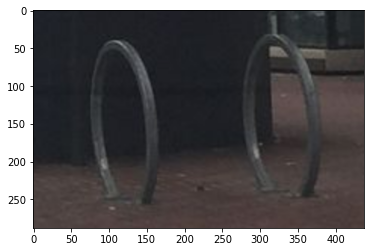

In [18]:
!wget https://i.imgur.com/ePJzE87.png
img = plt.imread('ePJzE87.png')
plt.imshow(img);

In [19]:
img = np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((2048, 1536)).convert('RGB'))
learn.predict(img)

('bike_rack', TensorBase(0), TensorBase([0.7253, 0.2747]))

--2022-06-02 18:46:15--  https://i.imgur.com/ppHmAa6.png
Resolving i.imgur.com (i.imgur.com)... 146.75.28.193
Connecting to i.imgur.com (i.imgur.com)|146.75.28.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335931 (328K) [image/png]
Saving to: ‘ppHmAa6.png’

ppHmAa6.png         100%[===================>] 328.06K  1.16MB/s    in 0.3s    

2022-06-02 18:46:16 (1.16 MB/s) - ‘ppHmAa6.png’ saved [335931/335931]



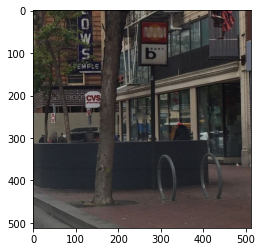

In [20]:
!wget https://i.imgur.com/ppHmAa6.png
img = plt.imread('ppHmAa6.png')
plt.imshow(img)

In [21]:
img = np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((2048, 1536)).convert('RGB'))
learn.predict(img)

('ev_charger', TensorBase(1), TensorBase([0.4663, 0.5337]))

--2022-06-02 18:46:17--  https://i.imgur.com/Dqvu6lo.png
Resolving i.imgur.com (i.imgur.com)... 146.75.28.193
Connecting to i.imgur.com (i.imgur.com)|146.75.28.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3514937 (3.4M) [image/png]
Saving to: ‘Dqvu6lo.png’

Dqvu6lo.png         100%[===================>]   3.35M  6.41MB/s    in 0.5s    

2022-06-02 18:46:18 (6.41 MB/s) - ‘Dqvu6lo.png’ saved [3514937/3514937]



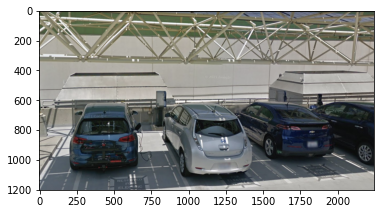

In [22]:
!wget https://i.imgur.com/Dqvu6lo.png
img = plt.imread('Dqvu6lo.png')
plt.imshow(img);

In [23]:
img = np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((2048, 1536)).convert('RGB'))
learn.predict(img)

('ev_charger', TensorBase(1), TensorBase([0.2692, 0.7308]))

--2022-06-02 18:46:20--  https://i.imgur.com/5vp4N7Z.png
Resolving i.imgur.com (i.imgur.com)... 146.75.28.193
Connecting to i.imgur.com (i.imgur.com)|146.75.28.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1216339 (1.2M) [image/png]
Saving to: ‘5vp4N7Z.png’

5vp4N7Z.png         100%[===================>]   1.16M  2.68MB/s    in 0.4s    

2022-06-02 18:46:21 (2.68 MB/s) - ‘5vp4N7Z.png’ saved [1216339/1216339]



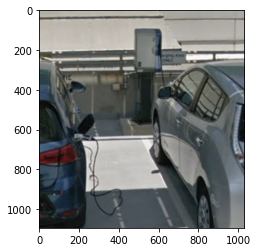

In [24]:
!wget https://i.imgur.com/5vp4N7Z.png
img = plt.imread('5vp4N7Z.png')
plt.imshow(img);

In [25]:
img = np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((2048, 1536)).convert('RGB'))
learn.predict(img)

('ev_charger', TensorBase(1), TensorBase([0.2885, 0.7115]))

--2022-06-02 18:46:22--  https://i.imgur.com/qUyOxCR.jpg
Resolving i.imgur.com (i.imgur.com)... 146.75.28.193
Connecting to i.imgur.com (i.imgur.com)|146.75.28.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218134 (213K) [image/jpeg]
Saving to: ‘qUyOxCR.jpg’

qUyOxCR.jpg         100%[===================>] 213.02K  1.03MB/s    in 0.2s    

2022-06-02 18:46:23 (1.03 MB/s) - ‘qUyOxCR.jpg’ saved [218134/218134]



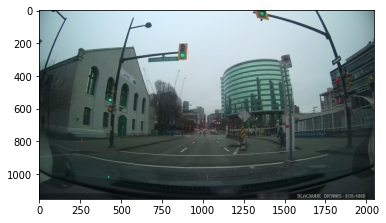

In [26]:
!wget https://i.imgur.com/qUyOxCR.jpg
img = plt.imread('qUyOxCR.jpg')
plt.imshow(img);

In [27]:
img = np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((2048, 1536)).convert('RGB'))
learn.predict(img)

('ev_charger', TensorBase(1), TensorBase([0.3320, 0.6680]))

--2022-06-02 18:46:25--  https://i.imgur.com/OFB8AZx.png
Resolving i.imgur.com (i.imgur.com)... 146.75.28.193
Connecting to i.imgur.com (i.imgur.com)|146.75.28.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 146145 (143K) [image/png]
Saving to: ‘OFB8AZx.png’

OFB8AZx.png         100%[===================>] 142.72K   759KB/s    in 0.2s    

2022-06-02 18:46:26 (759 KB/s) - ‘OFB8AZx.png’ saved [146145/146145]



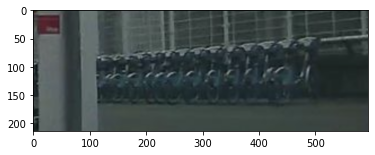

In [28]:
!wget https://i.imgur.com/OFB8AZx.png
img = plt.imread('OFB8AZx.png')
plt.imshow(img);

In [29]:
img = np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((2048, 1536)).convert('RGB'))
learn.predict(img)

('ev_charger', TensorBase(1), TensorBase([0.3202, 0.6798]))

In [30]:
learn.export('model.pkl')

# Conclusion
Created a highly accurate ev charger vs bike rack classifier. However, the test dataset features dash cam images and won't accurately predict based on the training images given. There doesn't seem to be any matching training data that I could find (searched COCO, KITTI, BDD, Cityscapes to no avail. They don't have a class for bike racks or EV chargers) or scrape. I'll be naively splitting images in the hope that the split image will resemble training images